In [30]:
# Parameters

ds =   2# downscale factor for probability smoothing
p_threshold = 0.9# (average) probability threshold

import torch
import alvq
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob as glob
import os
net = torch.load('pix-classifier-alvq-2025-07-09.pt', weights_only=False)

# img = cv2.imread(r"c:\Users\anush\Documents\PostDoc\Croptimal datasets\NAKFielddataset\Spunta\savepatches_demo\12_healthybox_RGBpatch_2.png")
# Path where your images are stored
folder = r"C:\Users\anush\Documents\PostDoc\Croptimal datasets\NAKFielddataset\Spunta\data\savepatches\\"

# Find all files that contain 'RGBpatch' and end with .png (or .jpg, etc.)
files = glob.glob(os.path.join(folder, "*RGBpatch*.png"))

print(f"Found {len(files)} images")

# Read all images into a list
for i, f in enumerate(files):
    print(f"image: {f}")
   
    img = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) 
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    rgb_feats = (img[..., 0:3].astype(np.float32) * (1/255)).reshape(-1, 3)

    with torch.no_grad():
        scalar = net.probabilities(torch.from_numpy(rgb_feats))

    width = img.shape[1]
    height = img.shape[0]
    # if width==0 or height==0 or img.shape[2]==0:
    #     print(f"Failed to load image: {f}")
    #     continue
    scalar = scalar[..., 1].reshape(img.shape[0:2])
    scalar_orig = scalar
    scalar = cv2.resize(scalar.numpy(), (width // ds, height // ds), interpolation=cv2.INTER_AREA)
    scalar = cv2.resize(scalar, (width, height), interpolation=cv2.INTER_LINEAR)

    # fig, axes = plt.subplots(2, 2, figsize=(10,5))
    # axes[0][0].imshow(img)
    img2 = img.copy()
    img2[scalar < p_threshold, :] = 0
    folder, filename = os.path.split(f)
    name, ext = os.path.splitext(filename)

    # New filename with "_with_seg"
    output_path = os.path.join(folder, 'downsamplefilter', f"{name}.png")

    # OpenCV expects BGR, so convert back before saving
    cv2.imwrite(output_path, cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

    

    # mask = (scalar_orig > 0).cpu().numpy().astype(np.float32)  # (H, W) binary mask
    # axes[0][1].imshow(img)
    # axes[1][0].imshow(img2)
    # axes[1][1].imshow(scalar)

Found 2033 images
image: C:\Users\anush\Documents\PostDoc\Croptimal datasets\NAKFielddataset\Spunta\data\savepatches\0_healthybox_RGBpatch_0.png
image: C:\Users\anush\Documents\PostDoc\Croptimal datasets\NAKFielddataset\Spunta\data\savepatches\0_healthybox_RGBpatch_1.png
image: C:\Users\anush\Documents\PostDoc\Croptimal datasets\NAKFielddataset\Spunta\data\savepatches\0_healthybox_RGBpatch_10.png
image: C:\Users\anush\Documents\PostDoc\Croptimal datasets\NAKFielddataset\Spunta\data\savepatches\0_healthybox_RGBpatch_11.png
image: C:\Users\anush\Documents\PostDoc\Croptimal datasets\NAKFielddataset\Spunta\data\savepatches\0_healthybox_RGBpatch_12.png
image: C:\Users\anush\Documents\PostDoc\Croptimal datasets\NAKFielddataset\Spunta\data\savepatches\0_healthybox_RGBpatch_13.png
image: C:\Users\anush\Documents\PostDoc\Croptimal datasets\NAKFielddataset\Spunta\data\savepatches\0_healthybox_RGBpatch_14.png
image: C:\Users\anush\Documents\PostDoc\Croptimal datasets\NAKFielddataset\Spunta\data\s

In [32]:
import os
import cv2
import glob

folder = r"C:\Users\anush\Documents\PostDoc\Croptimal datasets\NAKFielddataset\Spunta\data\savepatches\downsamplefilter"
folder2 = r"C:\Users\anush\Documents\PostDoc\Croptimal datasets\NAKFielddataset\Spunta\data\savepatches\downsamplefilter\single_channel_pgm"
# Loop through all segmented RGB image
# s
for i, file in enumerate(glob.glob(os.path.join(folder, "*RGBpatch*.png"))):
    if i<3965:
        img = cv2.imread(file)  # BGR in OpenCV
        if img is None:
            print(f"⚠️ Could not read {file}")
            continue
        hsv_patch = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
        # Split into channels
        b, g, r = cv2.split(img)  # OpenCV loads as BGR
        h, s, v = cv2.split(hsv_patch)  # OpenCV loads as BGR
        # Build base name
        base = os.path.basename(file)
        name, ext = os.path.splitext(base)

        # Replace "RGBpatch" with single-channel names
        r_name = name.replace("RGBpatch", "Rpatch") + '.pgm'
        g_name = name.replace("RGBpatch", "Gpatch") + '.pgm'
        b_name = name.replace("RGBpatch", "Bpatch") + '.pgm'
        h_name = name.replace("RGBpatch", "Hpatch") + '.pgm'
        s_name = name.replace("RGBpatch", "Spatch") + '.pgm'

        # Save grayscale images
        cv2.imwrite(os.path.join(folder2, r_name), r)
        cv2.imwrite(os.path.join(folder2, g_name), g)
        cv2.imwrite(os.path.join(folder2, b_name), b)
        cv2.imwrite(os.path.join(folder2, h_name), h)
        cv2.imwrite(os.path.join(folder2, s_name), s)

        # print(f"✅ Saved {r_name}, {g_name}, {b_name}")


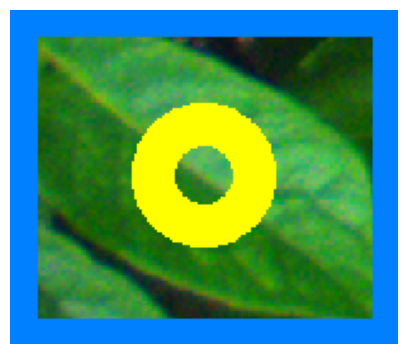

In [2]:
mask = (scalar >= p_threshold).astype(np.uint8)

img2 = img.copy()

output = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
labels = output[1]

for i in range(1, output[2].shape[0]):
    if (output[2][i, 4] >= 0):
        x_begin = output[2][i, 0]
        y_begin = output[2][i, 1]
        x_end = x_begin + output[2][i, 2]
        y_end = y_begin + output[2][i, 3]
        cv2.rectangle(img2, [x_begin, y_begin], [x_end, y_end], color=(0,127,255), thickness=20)
        cv2.circle(img2, (int(output[3][i, 0]), int(output[3][i, 1])), 20, (255, 255, 0), thickness=15)    

plt.figure(figsize=(5,5))
plt.imshow(img2)
plt.axis('off');